[View in Colaboratory](https://colab.research.google.com/github/shalini0289/Colab/blob/master/sentiment_analysis.ipynb)

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14886833091743077709]

In [0]:
from google.colab import auth
from googleapiclient.discovery import build

In [0]:
import io , requests
import sys

import pandas as pd
import os
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
SOURCE_FOLDER=''

In [0]:
def get_parent_folder(folder_name):
  page_token = None
  folder_array = []
  query = "name='%s' and mimeType='application/vnd.google-apps.folder'" % folder_name
  while True:
      response = drive_service.files().list(q=query,
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name)',
                                          pageToken=page_token).execute()
      for file in response.get('files', []):
          # Process change
          #print (file.get('name'), file.get('id'))
          folder_array.append({"name" : file.get('name'), "id" : file.get('id')})
      page_token = response.get('nextPageToken', None)
      if page_token is None:
          break
  return folder_array

In [0]:
def get_files_from_parent(parent_id):
  page_token = None
  folder_array = dict()
  query = "'%s' in parents" % parent_id
  while True:
      response = drive_service.files().list(q=query,
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name)',
                                          pageToken=page_token).execute()
      for file in response.get('files', []):
          # Process change
          #print (file.get('name'), file.get('id'))
          folder_array.update({file.get('name'):file.get('id')})
      page_token = response.get('nextPageToken', None)
      if page_token is None:
          break
  return folder_array

In [0]:
def get_file_buffer(file_id, verbose=0):
  from googleapiclient.http import MediaIoBaseDownload
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    progress, done = downloader.next_chunk()
    if verbose:
      sys.stdout.flush()
      sys.stdout.write('\r')
      percentage_done = progress.resumable_progress * 100/progress.total_size
      sys.stdout.write("[%-100s] %d%%" % ('='*int(percentage_done), int(percentage_done)))
  downloaded.seek(0)
  return downloaded

In [14]:
parent_folder = get_parent_folder('av-sa')
print(parent_folder)
parent_folder[0]["id"]

[{'name': 'av-sa', 'id': '1uOG8csXYChpdzul_0v5lPgY-N5ssebG5'}]


'1uOG8csXYChpdzul_0v5lPgY-N5ssebG5'

In [15]:
input_file_meta = get_files_from_parent(parent_folder[0]["id"])
print(input_file_meta)

{'test_tweets_anuFYb8.csv': '1DXtnnPd4THLQj6kUAU2JODxaQd3r1EXh', 'train_E6oV3lV.csv': '1FO1N6elMtXjPAh1Sz6BHojgHS-tqM8U3'}


In [16]:
for file, id in input_file_meta.items():
  downloaded = get_file_buffer(id, verbose=1)
  dest_file = os.path.join(SOURCE_FOLDER, file)
  print("processing %s data" % file)
  with open(dest_file, "wb") as out:
    out.write(downloaded.read())
    print("Done %s" % dest_file)

[====================================================================================================] 100%processing test_tweets_anuFYb8.csv data
Done test_tweets_anuFYb8.csv
[====================================================================================================] 100%processing train_E6oV3lV.csv data
Done train_E6oV3lV.csv


In [0]:
train=pd.read_csv(os.path.join(SOURCE_FOLDER,'train_E6oV3lV.csv'))
test=pd.read_csv(os.path.join(SOURCE_FOLDER,'test_tweets_anuFYb8.csv'))

In [0]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [22]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


**Combine testa nd train data for convenience so that same operations of cleaning we dont have to perform twice. **


---



In [0]:
combi = train.append(test, ignore_index=True)

**format function to remove particular pattern from the text samples**

---



In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt   

In [0]:
# remove twitter handles (@user)
# @[\w]* -  a regular expression which will pick any word starting with ‘@

combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

In [0]:
# remove special characters, numbers, punctuations
# replace everything except characters and hashtags with spaces

combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [0]:
#remove short words like : oh, hm etc

combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [30]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [31]:
# splitting a string of text into tokens(individual terms or words)

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [32]:
# Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc)

from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [0]:
#combine tokens
for i in range(len(tokenized_tweet)):
 tokenized_tweet[i] = ",".join(tokenized_tweet[i])
combi['tidy_tweet'] = tokenized_tweet

**WordCloud Visualization** 

---


A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

In [41]:
!pip install wordcloud

    100% |████████████████████████████████| 368kB 5.1MB/s 


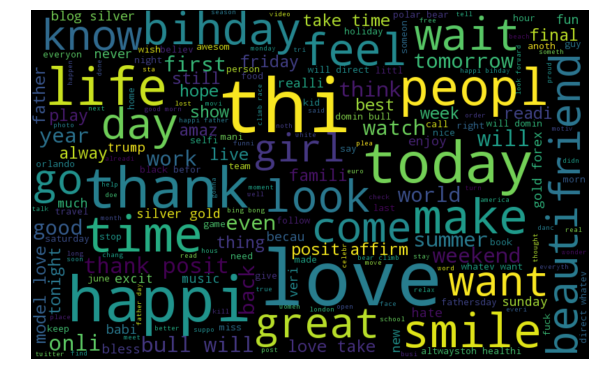

In [42]:
all_words = ' '.join([text for text in combi['tidy_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**plot separate wordclouds for the classes not (racist/sexist or not)**

---



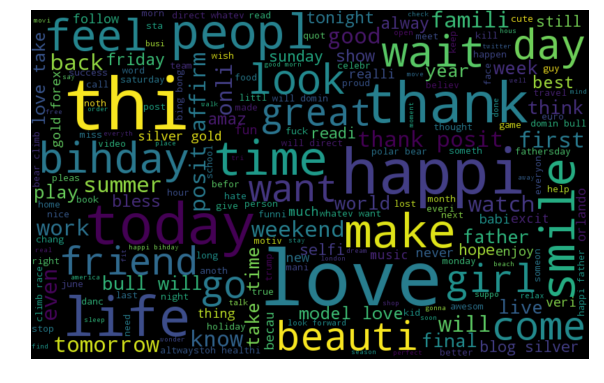

In [43]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**plot separate wordclouds for the classes (racist/sexist)**

---



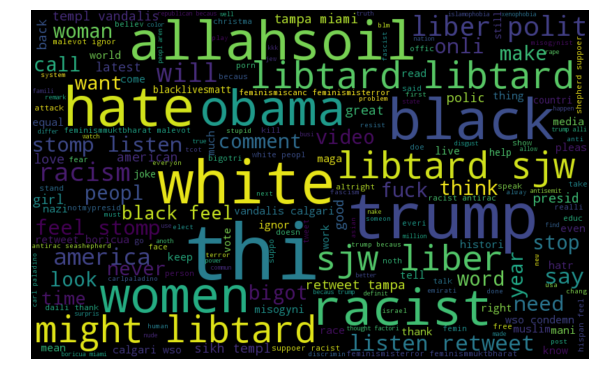

In [45]:
negative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [0]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [0]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


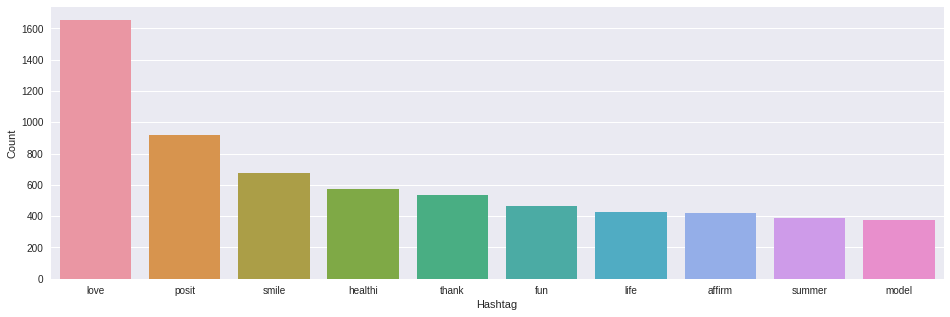

In [48]:
#plot the top n hashtags in the non-racist/sexist tweets.
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


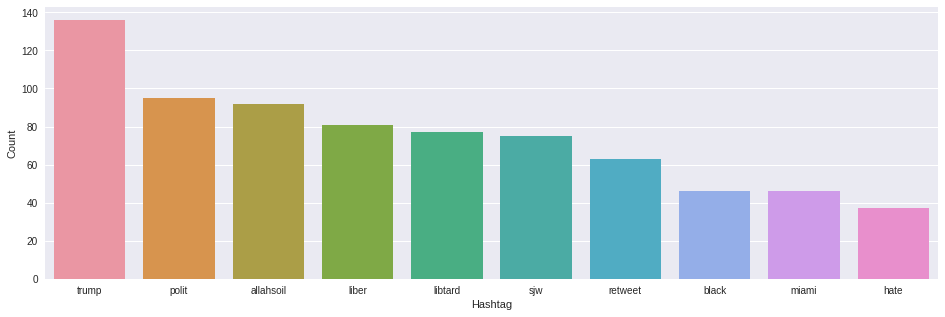

In [49]:
#plot the top n hashtags in the racist/sexist tweets.
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


** Extracting Features from Cleaned Tweets**

---

To analyze a preprocessed data, it needs to be converted into features. Depending upon the usage, text features can be constructed using assorted techniques – Bag-of-Words, TF-IDF, and Word Embeddings. In this article, only Bag-of-Words and TF-IDF are covered.


**Bag-of-Words Features**

---
Bag-of-Words is a method to represent text into numerical features. Consider a corpus (a collection of texts) called C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a list, and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).




In [0]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

**TF-IDF Features**

---

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire corpus.

TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

** Building model using Bag-of-Words features**

---



In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5307820299500832

In [0]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
my_sub = os.path.join(SOURCE_FOLDER, "sub_lreg_bow.csv")
submission.to_csv(my_sub, index=False) # writing data to a CSV file

**Building model using TF-IDF features**

---



In [55]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.5446507515473032